# ***Submission***

### This report details my findings and solution process.

### All required libraries:

In [17]:
import numpy as np, pandas as pd, scipy as sp
from pathlib import Path
import joblib, json, warnings, gc, os, random, sys

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_validate, RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, roc_auc_score, 
                             f1_score, classification_report,
                             matthews_corrcoef, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.feature_selection import (VarianceThreshold,
                                       mutual_info_classif,
                                       SelectKBest)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
import umap.umap_ as umap

from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import xgboost as xgb
from sklearn.preprocessing import KBinsDiscretizer
!pip install faiss-cpu
import faiss
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

# ***EDA***

In [4]:
df_train = pd.read_csv('/kaggle/input/job-task/train_data.csv', header=None)
df_train_labels = pd.read_csv('/kaggle/input/job-task/train_labels.csv', header=None)

print("Data_Set: ", df_train.head(5))
print("Shape   : ", df_train.shape)

Data_Set:         0        1          2          3          4         5        6     \
0  -368.628  -20.998 -43561.360 -50837.137 -58284.664  -321.016 -460.117   
1  -675.786  -15.485  17229.290  38412.840  60946.580  -790.845 -189.443   
2   386.829 -141.141  46403.641  39583.147  -7400.224  1047.673 -187.484   
3    -8.509  -99.627 -46320.037  -2812.081  28036.897  -356.849 -186.106   
4  1412.017  330.190   2504.745 -51110.910  46252.799  -218.928 -186.642   

       7        8         9     ...      9990      9991     9992     9993  \
0  -708.655 -361.376  -718.630  ...   -45.656  -777.051  893.161  173.162   
1   269.238  -62.461  -528.154  ...   230.085   -75.490 -883.604   19.226   
2   372.604  263.217 -1048.317  ...  -362.909  -494.809  440.159 -345.019   
3  -433.045 -340.454 -1087.733  ...  1179.831 -1608.128  271.064 -650.372   
4  1149.771   -2.678    41.092  ...  -383.297   358.533 -786.886  168.208   

       9994      9995     9996      9997      9998      9999  
0  -81

### Dataset imbalance check

0
 1    90.053
-1     9.947
Name: proportion, dtype: float64

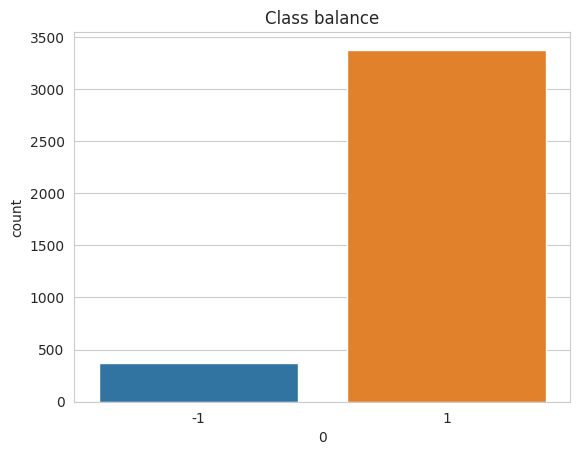

In [9]:
y = df_train_labels[0].astype(int)
X = df_train

display(y.value_counts(normalize=True).mul(100).round(3))

sns.countplot(x=y)
plt.title("Class balance")
plt.show()

### No duplicates, all columns are float64.

In [78]:
print(X.duplicated().sum())
print(X.dtypes.value_counts())

0
float64    10000
Name: count, dtype: int64


### Missing value

In [79]:
na_counts = X.isna().sum()
print("Columns with missing values:", (na_counts > 0).sum())

Columns with missing values: 0


### See the basic statistics of the dataset.

In [80]:
desc = X.sample(1000, random_state=SEED).describe().T
display(desc[['mean','std','min','25%','50%','75%','max']].head())

,mean,std,min,25%,50%,75%,max
0,47.261175,797.151668,-2317.264,-479.43925,36.1010,585.93300,2737.221
1,5.086199,185.770067,-605.054,-117.25975,0.7685,130.75975,733.215
2,71.299092,29206.901020,-106509.076,-19892.55000,-247.7040,18096.16425,134380.020
3,-5214.705706,65113.891658,-203388.155,-52903.39125,-4781.2200,41491.30650,208958.242
4,-12.689206,49798.759675,-151208.787,-33946.74325,-997.0175,33328.33775,144760.155


### We can see that the dataset's features have high variance.

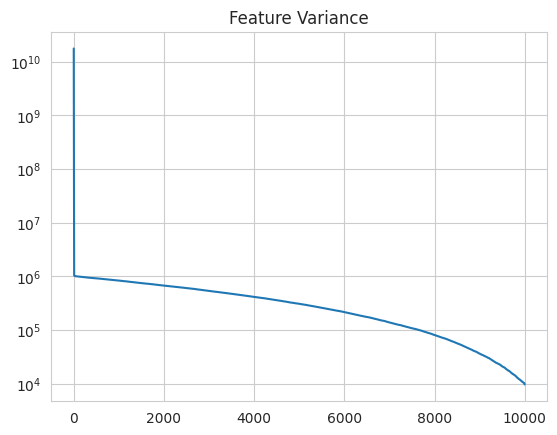

In [81]:
var = X.var().sort_values(ascending=False)
sns.lineplot(data=var.reset_index(drop=True))
plt.yscale('log')
plt.title("Feature Variance")
plt.show()

# 

### 9 randomly selected feature are normally distributed

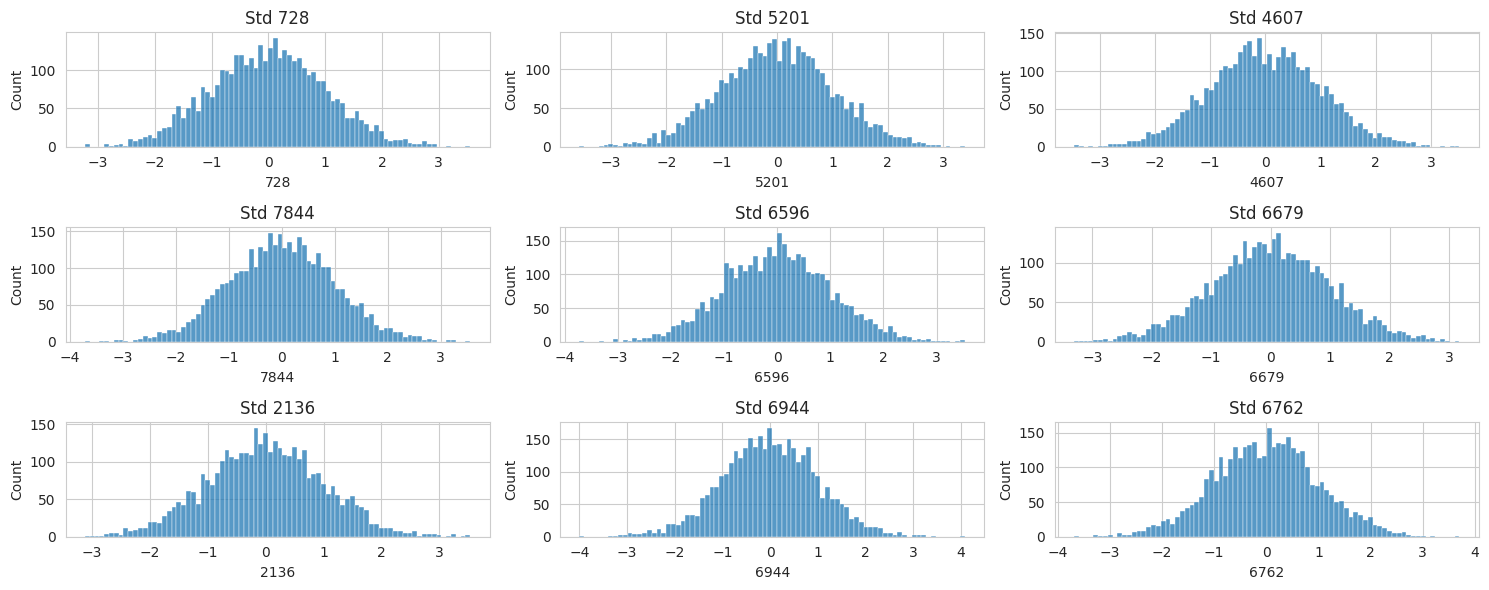

In [82]:
scaler = StandardScaler().fit(X)
X_std = pd.DataFrame(scaler.transform(X), columns=X.columns)

feat_samp = np.random.choice(X.columns, 9, replace=False)
fig, ax = plt.subplots(3, 3, figsize=(15,6))
for i, col in enumerate(feat_samp):
    sns.histplot(X_std[col], bins=80, ax=ax.flat[i], kde=False)
    ax.flat[i].set_title(f"Std {col}")
plt.tight_layout()
plt.show()

### In the data set there are no outliyers (standart dev > 6)

In [83]:
is_outlier = (np.abs(X_std) > 6).any(axis=1)
print("Rows with any feature > 6σ :", is_outlier.sum())

Rows with any feature > 6σ : 0


In [84]:
means = X.groupby(y).mean()
meds  = X.groupby(y).median()
diff  = (means.loc[1] - means.loc[-1]).abs().sort_values(ascending=False)
print("Top 20 columns by mean difference between classes")
display(diff.head(20))

Top 20 columns by mean difference between classes


4       5744.627840
3       3369.009292
1017    1990.667803
2       1501.031957
5432     684.245891
1721     178.775611
7390     174.450424
1779     170.474009
8421     162.715133
2586     160.427186
7485     158.989989
6148     148.069254
6253     147.008467
9034     146.169136
3392     144.623023
5834     144.589520
6322     142.705977
3375     141.323427
9613     141.144631
4018     139.893043
dtype: float64

### High-variance feature analysis

Top 5 variance columns : [1017, 3, 4, 5432, 2]


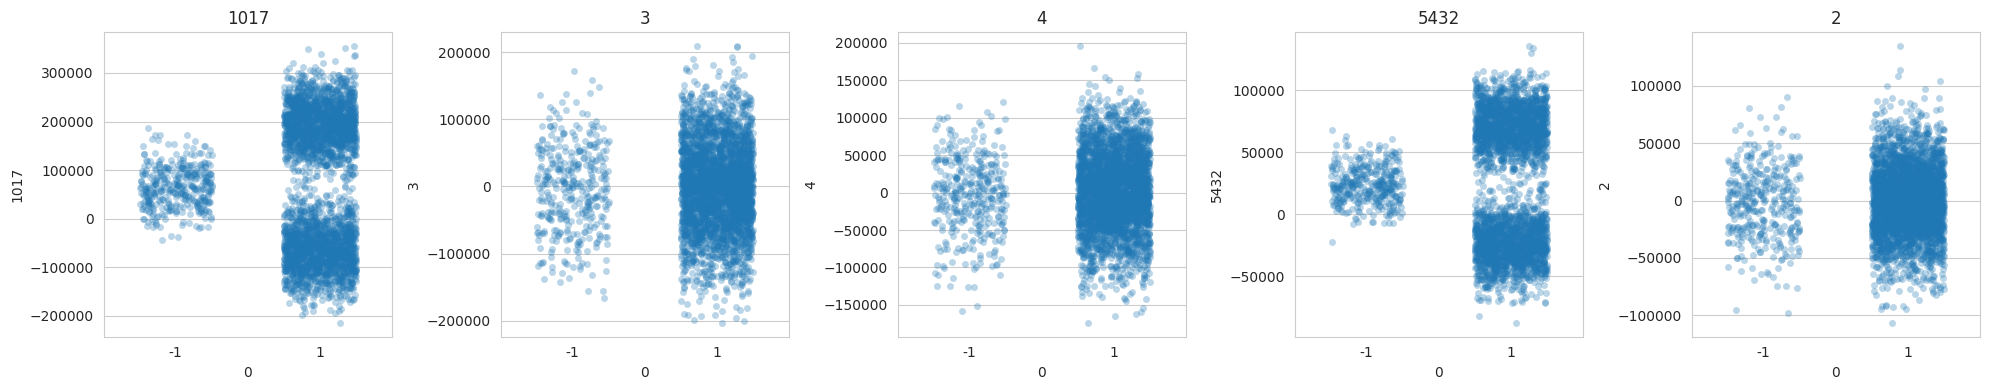

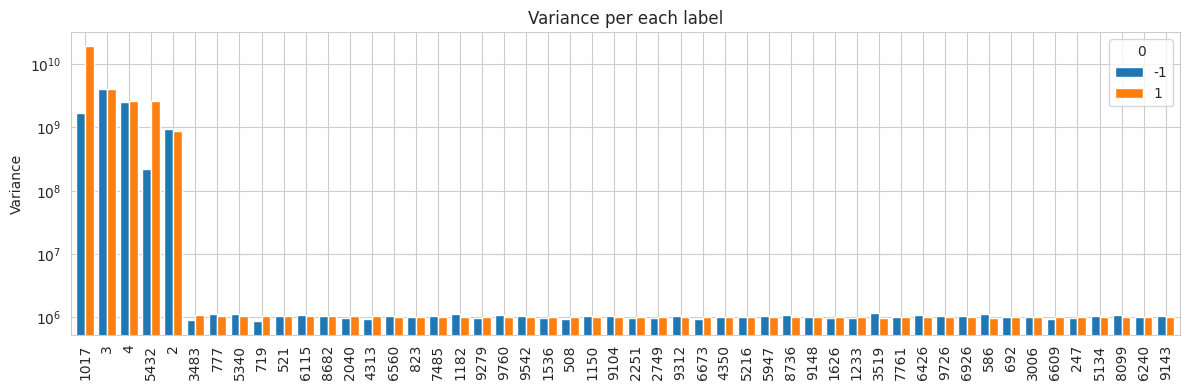

In [85]:
var = X.var().sort_values(ascending=False)
top_var_cols = var.head(5).index.tolist()
print("Top 5 variance columns :", top_var_cols)

fig, ax = plt.subplots(1, len(top_var_cols), figsize=(4*len(top_var_cols),4))
for i, col in enumerate(top_var_cols):
    sns.stripplot(x=y, y=X[col], ax=ax[i], alpha=0.3, jitter=0.25)
    ax[i].set_title(col)
plt.tight_layout()
plt.show()

top50 = var.head(50).index
var_by_cls = X[top50].groupby(y).var().T
var_by_cls.plot(kind='bar', figsize=(12,4), width=0.8, logy=True)
plt.title("Variance per each label")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()

### ***Note***: Features 5432 and 1017 have more distinct labels than other features.

In [86]:
mi = mutual_info_classif(X, y, discrete_features=False, random_state=SEED)
mi_s = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Top 20 features by mutual information with label")
display(mi_s.head(20))

Top 20 features by mutual information with label


5432    0.196537
1017    0.186498
716     0.018380
9335    0.016616
8090    0.016425
1916    0.016236
8518    0.016023
3864    0.014756
6206    0.014735
3575    0.014693
1952    0.014649
7387    0.014549
6738    0.014430
8857    0.014387
3087    0.014307
2344    0.014283
1794    0.014182
7954    0.014105
2998    0.014099
4765    0.014071
dtype: float64

### The features 5432 and 1017 exhibit mutual information more than 10x higher than other features.

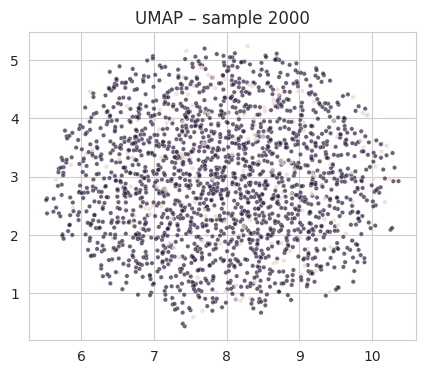

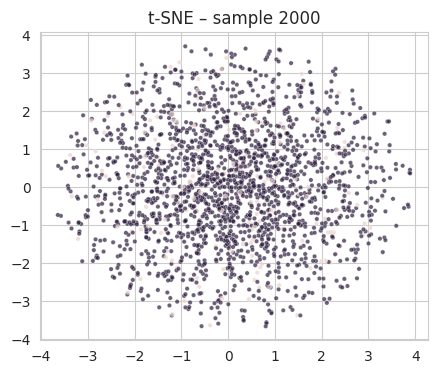

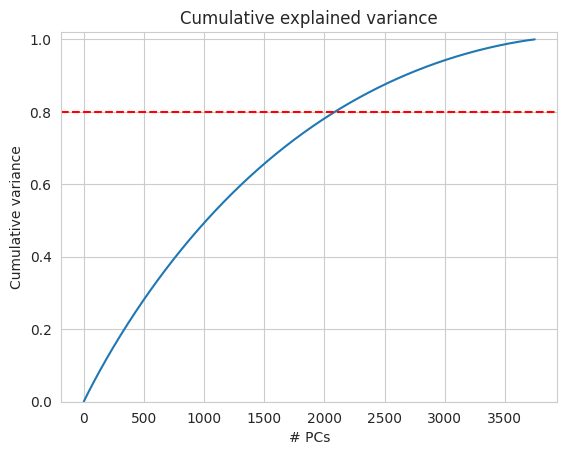

PCs for 80% variance: 2088


In [87]:
sub_idx = np.random.choice(len(X_std), 2000, replace=False)

# UMAP
umap_emb = umap.UMAP(random_state=SEED).fit_transform(X_std.iloc[sub_idx])
plt.figure(figsize=(5,4))
sns.scatterplot(x=umap_emb[:,0], y=umap_emb[:,1], hue=y.iloc[sub_idx], s=10, alpha=0.7, legend=False)
plt.title(f"UMAP – sample {len(sub_idx)}")
plt.show()

# t-SNE
tsne_emb = TSNE(random_state=SEED, init='pca', learning_rate='auto').fit_transform(X_std.iloc[sub_idx])
plt.figure(figsize=(5,4))
sns.scatterplot(x=tsne_emb[:,0], y=tsne_emb[:,1], hue=y.iloc[sub_idx], s=10, alpha=0.7, legend=False)
plt.title(f"t-SNE – sample {len(sub_idx)}")
plt.show()

# PCA 
pca = PCA().fit(X_std)
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(cum_var)
plt.ylim(0, 1.02)
plt.xlabel("# PCs")
plt.ylabel("Cumulative variance")
plt.axhline(0.8, ls='--', c='r')
plt.title("Cumulative explained variance")
plt.show()

print("PCs for 80% variance:", np.searchsorted(cum_var, 0.8) + 1)

#### Explaining 80% of the variance requires 2,000 PCA components, an unusually high number that suggests the underlying structure is nonlinear or has little consistent pattern.

### Correlation

In [91]:
cols = [5432, 1017]

print("Pairwise corr:", X[cols].corr().round(3))
print("\nCorr with target:\n", X[cols].corrwith(y))

Pairwise corr:        5432   1017
5432  1.000  0.945
1017  0.945  1.000

Corr with target:
 5432    0.004185
1017    0.004493
dtype: float64


#### Although the two suspicious features are highly correlated, their low correlation with the labels indicates limited linear predictive value; nonlinear relationships may still be present.

### **Let's prove it:**

In [92]:
susp_cols = [5432, 1017]
X_top = X[susp_cols]

cv = StratifiedKFold(5, shuffle=True, random_state=42)
proba = cross_val_predict(LogisticRegression(), X_top, y,
                          cv=cv, method='predict_proba')[:,1]
pred  = (proba >= 0.5).astype(int)*2 - 1   # convert to {-1,1}

print("2-feature MCC :", matthews_corrcoef(y, pred))
print("2-feature ROC :", roc_auc_score(y, proba))

2-feature MCC : -0.22844104668196566
2-feature ROC : 0.5063999409346144


In [93]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)
proba = cross_val_predict(LogisticRegression(), X, y,
                          cv=cv, method='predict_proba')[:,1]
pred  = (proba >= 0.5).astype(int)*2 - 1

print("2-feature MCC :", matthews_corrcoef(y, pred))
print("2-feature ROC :", roc_auc_score(y, proba))

2-feature MCC : -0.0016020760802008883
2-feature ROC : 0.4889315913278677


#### Both outputs are just random selection, we need a more non-linear and complex method to capture these patterns

### Independence across features

In [94]:
results = []

selected_columns = df_train.columns[:20]

for col in selected_columns:
    corrs = df_train.corrwith(df_train[col]).drop(col)
    max_corr = corrs.abs().max()
    max_corr_feature = corrs.abs().idxmax()
    results.append({
        'column': col,
        'max_corr_value': max_corr,
        'max_corr_feature': max_corr_feature
    })


result_df = pd.DataFrame(results)
print(result_df)

    column  max_corr_value  max_corr_feature
0        0        0.065733              8909
1        1        0.068561              9088
2        2        0.066924              2795
3        3        0.066449              1825
4        4        0.062128              6075
5        5        0.068930              1410
6        6        0.074406              4179
7        7        0.069034              7683
8        8        0.059857              3792
9        9        0.065110               807
10      10        0.065072              5522
11      11        0.063392              4506
12      12        0.072238              9100
13      13        0.063749              4011
14      14        0.068113              4889
15      15        0.061196              5379
16      16        0.059279               698
17      17        0.080202              9406
18      18        0.060894              4056
19      19        0.067668              3321


#### It's odd that 20 randomly chosen features are independent. Checking all 10,000 features would involve 50 million pairwise correlations, so we should use a different approach to assess correlation.

### The solution is Approximate Nearest Neighbors (ANN): find the pair of unit vectors with the maximal dot product. To build a small set of features, we need to search for and select the pairs with the highest correlation.

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(df_train.values)

X_t = X.T.astype('float32')

faiss.normalize_L2(X_t)
index = faiss.IndexFlatIP(X_t.shape[1])
index.add(X_t)

k = 2
similarities, indices = index.search(X_t, k)

max_corr = -1
best_pair = None
for i in range(len(indices)):
    sim = similarities[i, 1]
    if sim > max_corr:
        max_corr = sim
        best_pair = (i, indices[i, 1])

print(f"Max correlation ≈ {max_corr:.4f} between features {df_train.columns[best_pair[0]]} and {df_train.columns[best_pair[1]]}")


Max correlation ≈ 0.9448 between features 1017 and 5432


In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(df_train.drop([5432, 1017], axis=1).values)


X_t = X.T.astype('float32') 

faiss.normalize_L2(X_t)
index = faiss.IndexFlatIP(X_t.shape[1]) 
index.add(X_t)

k = 2
similarities, indices = index.search(X_t, k)

max_corr = -1
best_pair = None
for i in range(len(indices)):
    sim = similarities[i, 1]
    if sim > max_corr:
        max_corr = sim
        best_pair = (i, indices[i, 1])

print(f"Max correlation ≈ {max_corr:.4f} between features {df_train.columns[best_pair[0]]} and {df_train.columns[best_pair[1]]}")


Max correlation ≈ 0.0868 between features 189 and 4608


#### As we can see only 5432, 1017 are highly correlated, others are pretty independent

## ***What do we have so far:***

### 1. The dataset has 10,000 features and only 3,750 rows — a high‑dimensional, low‑sample‑sized data which increase the risk of overfitting and have the curse of dimensionality; We will use cross‑validation to conserve data.
### 1. Data set is imbalanced - we need to use MCC and ROC-AUC to evaluate the model. Because i need to make prediction of test_data dataset i will focus on MCC
### 2. Data set features have extreamly high variance - we should use normalization before any technique
### 3. Data set has been already preprocessed (no missing values, outiyers, features are normally distributed)
### 4. Patterns are complex and non-linear (we need 2000 PCA components to cover 80% of data)
### 5. All features except 2 of them have extreamly low correlation
### 6. Top features by mutual information with label are 5432, 1017 with 0.2 value, while all others are below 0.018
### 7. The best way is to use Dimensionality reduction firstly, but as we saw earlier PCA cannot cover the whole data easily, we need at least 1500 components and this will lead to overfitting.

### 

### Firstly, I will build a LightGBM model to cover complex patterns and plot feature importance to confirm my assumptions about 2 suspicious features.

[Fold 1] ROC-AUC: 0.9861 | MCC: 0.4136
[Fold 2] ROC-AUC: 0.9838 | MCC: 0.4063
[Fold 3] ROC-AUC: 0.9869 | MCC: 0.4101
[Fold 4] ROC-AUC: 0.9904 | MCC: 0.4016
[Fold 5] ROC-AUC: 0.9865 | MCC: 0.3907
Mean ROC-AUC: 0.98676125474587 +- 0.002095233580456769
Mean MCC    : 0.4044623735248498 +- 0.007947848243451499


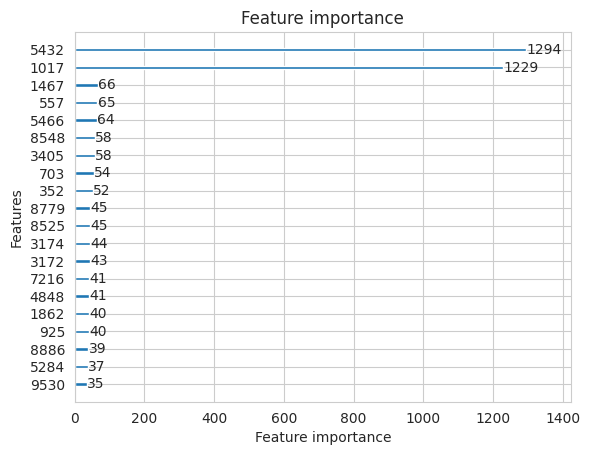

In [96]:
SEED = 42

X = df_train

magic_params = dict(
    objective='binary',
    learning_rate=0.01,
    n_estimators=10_000,
    is_unbalance=True,
    random_state=SEED,
    n_jobs=-1,
    bagging_fraction=0.8,
    bagging_freq=1,
    verbose=-1,
    device_type='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    num_leaves=64,
    min_data_in_leaf=192,
    feature_fraction=0.49,
    reg_lambda=1.197,
    reg_alpha=0.156
)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

auc_scores = []
mcc_scores = []

for fold , (train_ind, valid_ind) in enumerate(kf.split(X, y), 1):
    
    X_train, X_val = X.iloc[train_ind], X.iloc[valid_ind]
    y_train, y_val = y.iloc[train_ind], y.iloc[valid_ind]
    
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_val, label=y_val)
    
    callbacks = [lgb.early_stopping(200, verbose=False)]
    
    model = lgb.train(
        magic_params,
        train_dataset,
        valid_sets=[valid_dataset],
        callbacks=callbacks
    )
    
    proba_val = model.predict(X_val, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val, proba_val)
    mcc = matthews_corrcoef(y_val, (proba_val >= 0.5).astype(int))
    
    auc_scores.append(auc)
    mcc_scores.append(mcc)
    
    print(f"[Fold {fold}] ROC-AUC: {auc:.4f} | MCC: {mcc:.4f}")

print("Mean ROC-AUC:", np.mean(auc_scores), "+-", np.std(auc_scores))
print("Mean MCC    :", np.mean(mcc_scores), "+-", np.std(mcc_scores))

lgb.plot_importance(model, max_num_features=20)
plt.show()

[Fold 1] ROC-AUC: 0.5340 | MCC: 0.0000
[Fold 2] ROC-AUC: 0.4793 | MCC: 0.0000
[Fold 3] ROC-AUC: 0.5063 | MCC: 0.0000
[Fold 4] ROC-AUC: 0.5066 | MCC: 0.0000
[Fold 5] ROC-AUC: 0.5409 | MCC: 0.0000
Mean ROC-AUC: 0.5134123277913021 +- 0.02208158439110367
Mean MCC    : 0.0 +- 0.0


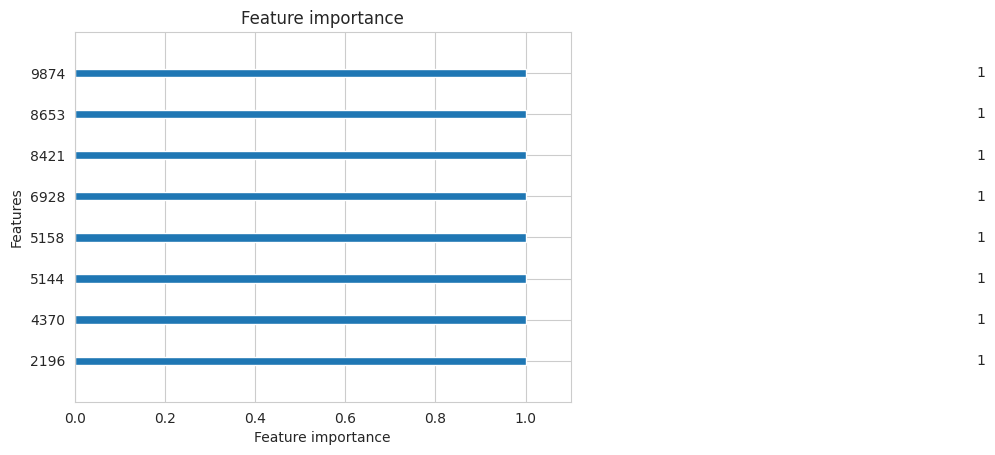

In [97]:
X = df_train.drop([5432, 1017], axis=1)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

auc_scores = []
mcc_scores = []

for fold , (train_ind, valid_ind) in enumerate(kf.split(X, y), 1):
    
    X_train, X_val = X.iloc[train_ind], X.iloc[valid_ind]
    y_train, y_val = y.iloc[train_ind], y.iloc[valid_ind]
    
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_val, label=y_val)
    
    callbacks = [lgb.early_stopping(200, verbose=False)]
    
    model = lgb.train(
        magic_params,
        train_dataset,
        valid_sets=[valid_dataset],
        callbacks=callbacks
    )
    
    proba_val = model.predict(X_val, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val, proba_val)
    mcc = matthews_corrcoef(y_val, (proba_val >= 0.5).astype(int))
    
    auc_scores.append(auc)
    mcc_scores.append(mcc)
    
    print(f"[Fold {fold}] ROC-AUC: {auc:.4f} | MCC: {mcc:.4f}")


print("Mean ROC-AUC:", np.mean(auc_scores), "+-", np.std(auc_scores))
print("Mean MCC    :", np.mean(mcc_scores), "+-", np.std(mcc_scores))

lgb.plot_importance(model, max_num_features=20)
plt.show()

## ***Conclusion***

### As we can see, almost all the information about the target comes from two features. This suggests the dataset is likely synthetic: 9,998 features appear to be randomly selected and contain only minimal information (yielding a ROC‑AUC of about 0.51), while two features show strong data leakage — most possibly they are transformed versions of the target or model predictions. In a real‑world scenario we would need to verify this to ensure data reliability. However, since this is a technical assignment, I will instead focus on finding an algorithm that maximizes MCC and ROC‑AUC

### Now the task is much simpler — effectively only two informative features. Although other features provide some signal, there is no reason to expect that a model tuned and optimized using just these two features would be outperformed by a more complex model trained on 10,000 features. Those extra features most likely add noise and aggravate the curse of dimensionality  and we can see it in MCC value in training using all 10_000 features: 0.4109. Additionally, using only two features greatly speeds up hyperparameter tuning, training, and prediction at deployment.

# ***Model***

#### Because of the nature of 2 features (that were probably transformed from the target directly or drom the model's prediction) i have dicided to use features transformation as preprocess step and XGBoost as main model (it was the best model from many others with best MCC score)

In [98]:
SEED = 42
np.random.seed(SEED)


def engineer_features(X_df):
    X = X_df.copy()
    colnames = list(X.columns)
    a = X.iloc[:, 0].values
    b = X.iloc[:, 1].values

    s = a + b
    d = a - b
    prod = a * b
    ratio = a / (b + 1e-8)
    ratio2 = b / (a + 1e-8)
    a2 = a**2
    b2 = b**2
    a3 = a**3
    b3 = b**3
    sa = np.sign(a) * np.log1p(np.abs(a))
    sb = np.sign(b) * np.log1p(np.abs(b))

    four_a = np.column_stack([np.sin(a), np.cos(a), np.sin(2*a), np.cos(2*a)])
    four_b = np.column_stack([np.sin(b), np.cos(b), np.sin(2*b), np.cos(2*b)])

    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
    kde.fit(a.reshape(-1,1))
    dens_a = np.exp(kde.score_samples(a.reshape(-1,1)))
    kde.fit(b.reshape(-1,1))
    dens_b = np.exp(kde.score_samples(b.reshape(-1,1)))

    kb = KBinsDiscretizer(n_bins=8, encode='onehot-dense', strategy='quantile')
    bins = kb.fit_transform(np.vstack([a,b]).T)

    pca = PCA(n_components=2)
    pca_xy = pca.fit_transform(np.vstack([a,b]).T)

    X_feats = np.column_stack([
        a, b, s, d, prod, ratio, ratio2,
        a2, b2, a3, b3, sa, sb, dens_a, dens_b,
        pca_xy
    ])

    X_feats = np.hstack([X_feats, four_a, four_b, bins])

    return X_feats

def best_threshold_mcc(y_true, y_prob):

    # Get thresholds from ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    mccs = []

    # Create a loop to go through each threshold
    for t in thresholds:
        # Create predictions
        y_pred = []
        for prob in y_prob:
            if prob >= t:
                y_pred.append(1)
            else:
                y_pred.append(0)

        # Compute the MCC
        mccs.append(matthews_corrcoef(y_true, y_pred))

    # Find the threshold that gives the highest MCC
    max_mcc = max(mccs)
    best_index = mccs.index(max_mcc)
    best_threshold = thresholds[best_index]

    # Return highest MCC and its threshold
    return float(best_threshold), float(max_mcc)

if set(np.unique(y)) <= {-1, 1}:
    y = y.copy()
    y = y.replace(-1, 0) if isinstance(y, pd.Series) else np.where(y == -1, 0, 1)
elif set(np.unique(y)) <= {0, 1}:
    pass

df_train_best = df_train[[5432, 1017]]

X = engineer_features(df_train_best)
y_np = np.asarray(y).astype(int)

print(f"Engineered features shape: {X.shape}")

# Best hyperparameters
xgb_params = {
    'learning_rate': 0.0012660,
    'max_depth': 3,
    'n_estimators': 883,
    'subsample': 0.64898,
    'colsample_bytree': 0.62617,
    'gamma': 4.75288,
    'random_state': SEED,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'verbosity': 0,
    'n_jobs': -1,
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

oof_proba = np.zeros(len(y_np), dtype=float)
fold_aucs, fold_mccs, fold_thrs = [], [], []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y_np), 1):
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y_np[tr_idx], y_np[va_idx]

    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr)

    proba_va = xgb_model.predict_proba(X_va)[:, 1]
    oof_proba[va_idx] = proba_va

    auc = roc_auc_score(y_va, proba_va)
    thr_best, mcc_best = best_threshold_mcc(y_va, proba_va)

    fold_aucs.append(auc)
    fold_mccs.append(mcc_best)
    fold_thrs.append(thr_best)

    print(f"Fold {fold}: ROC-AUC={auc:.6f}, best MCC={mcc_best:.6f}, thr={thr_best:.6f}")


oof_auc = roc_auc_score(y_np, oof_proba)
oof_thr_best, oof_mcc_best = best_threshold_mcc(y_np, oof_proba)

print("\nCV summary (5 folds):")
print(f"ROC-AUC: mean={np.mean(fold_aucs):.6f},  OOF={oof_auc:.6f}")
print(f"Best MCC: mean={np.mean(fold_mccs):.6f},  OOF={oof_mcc_best:.6f}")
print(f"OOF optimal threshold: {oof_thr_best:.6f}")

final_model = xgb.XGBClassifier(**xgb_params)
final_model.fit(X, y_np)
print("\nFinal model trained on full data.")

Engineered features shape: (3750, 41)
Fold 1: ROC-AUC=0.982558, best MCC=0.827176, thr=0.754230
Fold 2: ROC-AUC=0.984847, best MCC=0.837132, thr=0.728844
Fold 3: ROC-AUC=0.992385, best MCC=0.890291, thr=0.689903
Fold 4: ROC-AUC=0.989580, best MCC=0.841844, thr=0.594540
Fold 5: ROC-AUC=0.989136, best MCC=0.845201, thr=0.784954

CV summary (5 folds):
ROC-AUC: mean=0.987701,  OOF=0.987455
Best MCC: mean=0.848329,  OOF=0.841417
OOF optimal threshold: 0.728338

Final model trained on full data.


## Test data prediction

### Although the datasets dont have column names, we can still determine whether its columns order matches each other. By identifying high-variance features and examining their pairwise correlations, also If the detected features indices align with the indices from the training set, we can confidently conclude that the two datasets share the same column sequence.

In [99]:
test_data = pd.read_csv('/kaggle/input/job-task/test_data.csv', header=None)
X = test_data.copy()

Top-variance columns : [1017, 3, 4, 5432, 2]


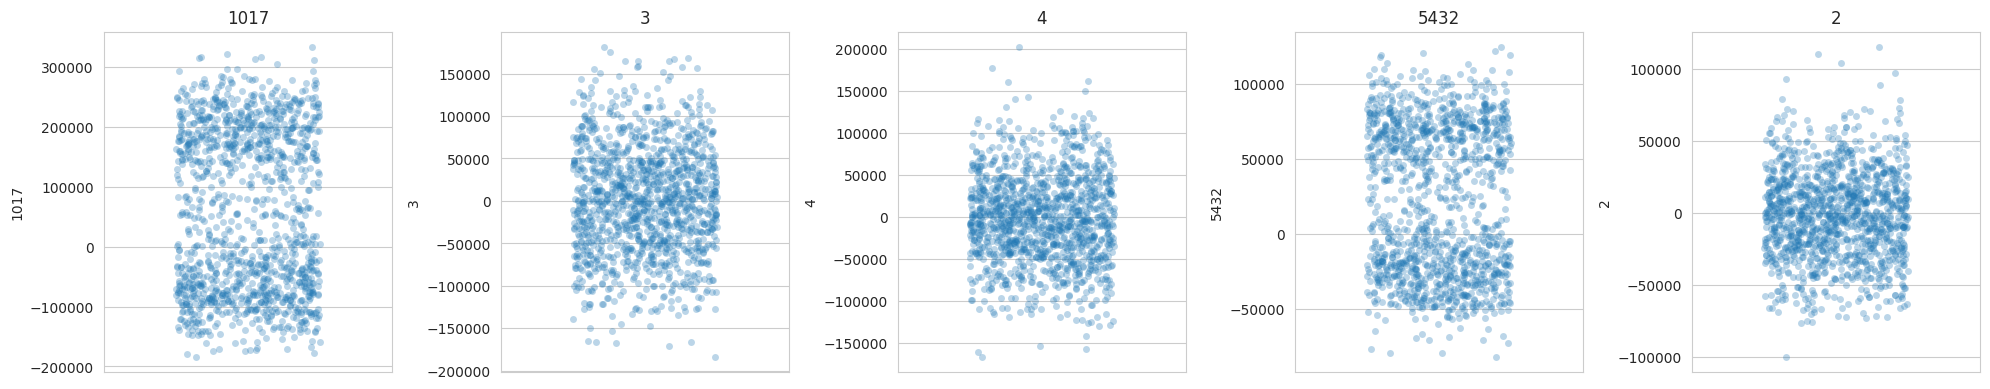

          5432      1017
5432  1.000000  0.946961
1017  0.946961  1.000000


In [100]:
var = X.var().sort_values(ascending=False)
top_var_cols = var.head(5).index.tolist()
print("Top-variance columns :", top_var_cols)

fig, ax = plt.subplots(1, len(top_var_cols), figsize=(4*len(top_var_cols), 4))
if len(top_var_cols) == 1:
    ax = [ax]
for i, col in enumerate(top_var_cols):
    sns.stripplot(y=X[col], ax=ax[i], alpha=0.3, jitter=0.25)
    ax[i].set_title(col)
    ax[i].set_xticks([])
    ax[i].set_xlabel('')
plt.tight_layout()
plt.show()

print(test_data[[5432, 1017]].corr())

In [101]:
X_test = engineer_features(test_data[[5432, 1017]])
threshold = oof_thr_best

predictions_proba = final_model.predict_proba(X_test)
prob_onnx = predictions_proba[:, 1] if predictions_proba.ndim == 2 else predictions_proba.ravel()

y_pred = (prob_onnx > threshold).astype(int)

predictions_df = pd.DataFrame({'test_predictions': y_pred})

print(predictions_df)
predictions_df.to_csv('test_labels.csv')

      test_predictions
0                    1
1                    1
2                    1
3                    0
4                    1
...                ...
1245                 1
1246                 1
1247                 0
1248                 1
1249                 1

[1250 rows x 1 columns]


# Final results

#### After training lots of pipelines and machine learning algorithms to optimize both MCC and ROC-AUC scores, I identified the best-performing models for each metric. The top model for ROC-AUC was achieved by using polynomial feature transformations of degree 2 with LogisticRegression model. Results: ROC-AUC of 0.990179 and an MCC of 0.48.

#### On the other hand, the model that maximized the MCC score was XGBoost, using various feature transformations, this model performed the best way: ROC-AUC - 0.988 and  MCC - 0.849374. Because of its significantly higher MCC score and classification task, I will use the XGBoost model for predictions on the test dataset.

### I believe my current model is pretty good, as evidenced by its high ROC-AUC and MCC scores. If my assessment is correct, the two primary features driving performance are transformations derived from the target variable or the model's predictions. This suggests that there may be a preprocessing step involving transformation that could elevate the model’s ROC-AUC and MCC scores to nearly 1.

### However, I suspect that some randomness has been applied to these features. After experimenting with various models and preprocessing strategies, I found that the best results were differs only a little +- 0.2%. From this i should conclude that the performance I've achieved is quite close to the upper limit.

